# COGS 108 - Final Project 
# Health Inspection

# Overview

In this project, I use the datasets provided in class to find if there is a correlation between an area's economic status (family income) and the number of health violations.




# Name & GitHub

- Name: Thuyet Ta
- GitHub Username: ThuyetTa

# Research Question

Can income of an area be used as a predictor for health inspection score? In other words, is there a correlation between wealth in an area and health inspection score?

## Background and Prior Work

One would think that a poorer communities in the United States would compromise on the cleanliness of a restaurant or food quality. Thus, the average income of the community would correlate with the health violations in the restaurants within that community. Studies have been done before that show a "relationship between inspection scores and rates of foodborne illness" (1). But could the rates of illness be attributed to anything else, such as living conditions? Another study states that "poor housing conditions are associated with a wide range of health conditions, including respiratory infections, asthma, lead poisoning, injuries, and mental health" (2). This suggests that poor living conditions, such as poorer communities are associated with health issues. So, could we attribute health issues to inspection scores or could it be because of poor communities? We cannot answer this question, but we can see if there is a correlation between wealth and health inspection score.

References:
- 1) Inspection Frequency, Sociodemographic Factors, and Food Safety Violations, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/
- 2) Housing and Health: Time Again for Public Health Action, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1447157/

# Hypothesis


There is a positive correlation between wealth in area and health inspection score.

# Dataset(s)


- Dataset Name: zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/
- Number of observations: 38

This dataset includes area zip codes and the respective income of that area. 

- Dataset Name: inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/
- Number of observations: 18466

This dataset includes data of restaurant's inspections, their location, score, etc. 

- Dataset Name: violations.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/
- Number of observations: 189802

This dataset is a collection of violations found by an inspector, violation code, a description, etc.

# Setup

In [1]:
#Imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Steps of data cleaning

1) Read in the datasets.

2) Drop data in the data set that I don't use

3) Check for invalid entries.

4) Merge data sets

5) Print result data set

In [2]:
df_inspections = pd.read_csv('inspections.csv')
df_violations = pd.read_csv('violations.csv')
df_zipcodes = pd.read_csv('zipcodes.csv')

In [3]:
df_inspections = df_inspections.loc[0:18466, ['hsisid','postalcode']]
df_violations = df_violations.drop(columns=['X.objectid','inspectdate','statecode','questionno','violationcode','severity'
                            ,'shortdesc','inspectedby','comments','pointvalue','observationtype','violationtype','count',
                            'cdcriskfactor','cdcdataitem'])
df_zipcodes = df_zipcodes.drop(columns=['percent_snap_benefits','percent_supplemental_security_income', 'percent_damilies_below_poverty_line', 'percent_nonwhite'])
df_zipcodes.columns = ['postalcode','family_income','household_income','per_capita_income']
df_zipcodes['postalcode'] = df_zipcodes['postalcode'].astype('str')

In [4]:
# Merge
df1 = pd.DataFrame(data=df_violations['hsisid'].value_counts(), columns=['hsisid','violations'])
df1 = df1.reset_index()
df1 = df1.drop(columns=['violations'])
df1.columns = ['hsisid','violations']

df2 = df1.merge(df_inspections)
df2 = df2.drop_duplicates()
df2 = df2.reset_index()
df2 = df2.drop(columns=['index'])

df3 = df2.merge(df_zipcodes)
df = df3.groupby('postalcode')['violations'].sum().to_frame()
df = df.reset_index()
df = df.merge(df_zipcodes)

df4 = df_inspections['postalcode'].value_counts().to_frame()
df4 = df4.reset_index()
df4.columns = ['postalcode','number_of_inspections']

df = df.merge(df4)
df['violations_per_inspect'] = df['violations']/df['number_of_inspections']
df

,postalcode,violations,family_income,household_income,per_capita_income,number_of_inspections,violations_per_inspect
0,27501,60,59408,51121,21631,6,10.000000
1,27502,4020,109891,95857,36763,578,6.955017
2,27511,8391,82292,67392,33139,908,9.241189
3,27513,7238,109736,87262,41232,598,12.103679
4,27518,2152,125432,98247,49865,344,6.255814
5,27519,2102,137193,121815,45778,322,6.527950
6,27520,79,67939,58455,25628,19,4.157895
7,27522,4,66250,59221,25513,2,2.000000
8,27523,212,89184,68342,36976,36,5.888889
9,27526,5041,74666,66025,28074,444,11.353604


# Data Analysis & Results

In [5]:
corrs = df.corr()
corrs

,violations,family_income,household_income,per_capita_income,number_of_inspections,violations_per_inspect
violations,1.000000,0.045680,0.039241,0.074365,0.964029,0.595797
family_income,0.045680,1.000000,0.878901,0.900628,0.054010,0.068390
household_income,0.039241,0.878901,1.000000,0.717824,0.054603,0.029361
per_capita_income,0.074365,0.900628,0.717824,1.000000,0.068405,0.121599
number_of_inspections,0.964029,0.054010,0.054603,0.068405,1.000000,0.465420
violations_per_inspect,0.595797,0.068390,0.029361,0.121599,0.465420,1.000000


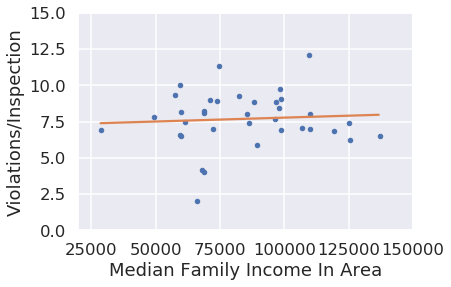

In [8]:
a1, b1 = np.polyfit(df['family_income'], df['violations_per_inspect'], 1)
m = np.arange(df['family_income'].min(), df['family_income'].max(), 3000)
f, ax = plt.subplots()
ax.plot(df['family_income'], df['violations_per_inspect'],'.')
ax.plot(m, a1*m+b1)
plt.xlabel('Median Family Income In Area'); plt.xlim([20000, 150000]);
plt.ylabel('Violations/Inspection'); plt.ylim([0, 15]);

In [7]:
outcome, predictors = patsy.dmatrices('violations_per_inspect ~ family_income', df)
res = sm.OLS(outcome, predictors).fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     violations_per_inspect   R-squared:                       0.005
Model:                                OLS   Adj. R-squared:                 -0.025
Method:                     Least Squares   F-statistic:                    0.1598
Date:                    Wed, 10 Jun 2020   Prob (F-statistic):              0.692
Time:                            23:07:41   Log-Likelihood:                -73.847
No. Observations:                      36   AIC:                             151.7
Df Residuals:                          34   BIC:                             154.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

# Ethics & Privacy

The datasets I used is within public domain. And I did not publish any private information. Therefore, I did not violate any privacy. As far as ethics goes, the information found is based upon the datasets provided and is not biased towards any race or economic class. Even though the research question deals with wealth status and health violations, there can be other contributing factors, not just economic status. Therefore, I did my best to have as good as ethics and privacy as possible in this project.

# Conclusion & Discussion

There is no strong correlation between the wealth of an area and the number of health violations in restaurants. Therefore, I cannot accept my hypothesis that there is a positive correlation between wealth in area and health inspection score.